In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def process_dyn_file(file_path):
    data = {
        'Type': [],
        'Barra': [],
        'Base': [],
        'H': [],
        'D': []
    }

    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file if not line.strip().startswith('!')]

    i = 0
    while i < len(lines):
        line = lines[i]

        if line.startswith('SM01'):
            if i + 2 < len(lines):
                barra = lines[i + 1].split()[0]
                values = lines[i + 2].split()
                if len(values) >= 6:
                    base, h, d = values[2], values[4], values[5]
                    data['Type'].append('SM01')
                    data['Barra'].append(float(barra))
                    data['Base'].append(float(base))
                    data['H'].append(float(h))
                    data['D'].append(float(d))
            i += 1

        elif line.startswith('SM04') or line.startswith('SM05'):
            sm_type = 'SM04' if line.startswith('SM04') else 'SM05'
            if i + 2 < len(lines):
                barra = lines[i + 1].split()[0]
                values = lines[i + 2].split()
                if len(values) >= 15:
                    base, h, d = values[7], values[13], values[14]
                    data['Type'].append(sm_type)
                    data['Barra'].append(float(barra))
                    data['Base'].append(float(base))
                    data['H'].append(float(h))
                    data['D'].append(float(d))
            i += 1

        else:
            i += 1

    # Create DataFrame
    df = pd.DataFrame(data)
    df['H_base100'] = (df['H'] * df['Base'])/100
    df['D_base100'] = (df['D'] * df['Base'])/100
    return df

def leitura_csv(csv_file_path, file_name):
    
    try:
        df = pd.read_csv(csv_file_path + file_name, sep=',')
        df = pd.DataFrame(df)

    except FileNotFoundError:
        print(f"The file {csv_file_path} was not found.")

    except Exception as e:
        print(f"An error occurred: {e}")
        
    return df

def calculate_inertia(df_geral, inertia_machines):
    # Ensure numeric columns are float
    inertia_machines['Barra'] = inertia_machines['Barra'].astype(float)
    df_geral['BUS_ID'] = df_geral['BUS_ID'].astype(float)
    df_geral[' Units'] = df_geral[' Units'].astype(float)

    # Merge DataFrames on Barra and BUS_ID
    merged_df = pd.merge(df_geral, inertia_machines, left_on='BUS_ID', right_on='Barra', how='left')

    # Calculate the new column for each Dia and Hora
    merged_df['total_h_bus'] = merged_df[' Units'] * merged_df['H_base100']

    # Aggregate total_h_bus by Dia, Hora, and REG
    pivot_df = merged_df.groupby(['Dia', 'Hora', 'REG'])['total_h_bus'].sum().unstack(fill_value=0).reset_index()
    
    pivot_df = pivot_df.rename(columns={"AC-RO": "INRT AC-RO", "Nordeste": "INRT Nordeste", "Norte": "INRT Norte", "Sudeste-Centro-Oeste": "INRT Sudeste-Centro-Oeste", "Sul": "INRT Sul"})

    return pivot_df

def calculate_inertia_type_region(df_geral, inertia_machines):
    # Ensure numeric columns are float
    inertia_machines['Barra'] = inertia_machines['Barra'].astype(float)
    df_geral['BUS_ID'] = df_geral['BUS_ID'].astype(float)
    df_geral[' Units'] = df_geral[' Units'].astype(float)

    # Merge DataFrames on Barra and BUS_ID
    merged_df = pd.merge(df_geral, inertia_machines, left_on='BUS_ID', right_on='Barra', how='left')

    # Calculate the new column for each Dia and Hora
    merged_df['total_h_bus'] = merged_df[' Units'] * merged_df['H_base100']

    # Aggregate total_h_bus by Dia, Hora, and REG
    pivot_df = merged_df.groupby(['Dia', 'Hora', 'REG', 'Gen_Type'])['total_h_bus'].sum().unstack(fill_value=0).reset_index()
    
    colunas_geracao = ['BIO', 'PCH', 'SIN', 'UHE', 'UTE']
    df_melt = pivot_df.melt(id_vars=['Dia', 'Hora', 'REG'], value_vars=colunas_geracao, 
                     var_name='Tipo_Geracao', value_name='Valor')

    # Agora vamos criar a coluna com o sufixo da região
    df_melt['Tipo_Geracao_Reg'] = df_melt['Tipo_Geracao'] + '_' + df_melt['REG']

    # Agora pivotamos os dados para ter uma coluna para cada tipo de geração + região
    df_final = df_melt.pivot_table(index=['Dia', 'Hora'], columns='Tipo_Geracao_Reg', values='Valor', aggfunc='first')

    # Reseta o índice para deixar o DataFrame no formato plano
    df_final = df_final.reset_index()

    return df_final

def process_scenario(cenario, base_path):
    csv_file_path = f'{base_path}/{cenario}/'
    
    # Process df_dyn
    file_name = 'vars.csv'
    df_dyn = leitura_csv(csv_file_path, file_name)
    df_dyn = df_dyn.groupby(by=['OP', 'Dia', 'Hora', 'Contigence', 'A_CODE']).agg({
        'A_RCFC': 'first', 
        'A_INRT': 'first', 
        'A_NDRC': 'first', 
        'C_NDRC': 'first', 
        'HRSV_I1': 'first', 
        'TRSV_I1': 'first', 
        'B_PGTM': 'first', 
        'C_PGTM': 'first'
    })
    df_dyn['PGTM_DIF'] = df_dyn['C_PGTM'] - df_dyn['B_PGTM']
    df_dyn['RSV_TOTAL'] = df_dyn['HRSV_I1'] + df_dyn['TRSV_I1']
    
    file_name = 'Df_ger.csv'
    df_geral = leitura_csv(csv_file_path, file_name)
    df_geral = df_geral.dropna(subset=[' Units'])

    #inertia_total  = calculate_inertia(df_geral, inertia_machines)
    inertia_total = calculate_inertia_type_region(df_geral,inertia_machines)

    # Merge all DataFrames
    merged_df = df_dyn.reset_index().merge(inertia_total, on=['Dia', 'Hora'], how='left')

    # Add scenario column
    merged_df['Cenario'] = cenario
    
    return merged_df

def process_all_cenarios(cenarios, base_path):
    dataframes = []
    
    for cenario in cenarios:
        df = process_scenario(cenario, base_path)
        dataframes.append(df)
        print(cenario)
    
    # Concatenate all scenario DataFrames
    all_scenarios_df = pd.concat(dataframes, axis=0)
    
    return all_scenarios_df


def plot_boxplot_inertia_FERV(data, contingence, ferv, variable, Yname, path_save_comp, name, limits=None):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'

    fig, ax = plt.subplots(figsize=(11, 5))
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    filtered_df = data[data['Contigence'] == contingence]

    # Verificar se a variável existe no DataFrame
    if variable not in filtered_df.columns:
        raise ValueError(f"A variável '{variable}' não existe no DataFrame.")

    # Definir os cenários esperados para o nível de penetração
    scenarios = [f'V1A1{ferv}', f'V2A2{ferv}', f'V3A3{ferv}']

    filtered_df = filtered_df[filtered_df['Cenario'].isin(scenarios)]

    data_plot = [filtered_df[filtered_df['Cenario'] == scenario][variable].values for scenario in scenarios]
    
    boxplot = ax.boxplot(data_plot, labels=scenarios, patch_artist=True, boxprops={'facecolor': 'white'},flierprops={'markerfacecolor': 'gray', 'marker': 'o'})

    # Set axis labels
    ax.set_xlabel('Cenário', fontsize=18)
    ax.set_ylabel(str(Yname), fontsize=18)

    # Set y-axis limits to zoom into quartiles
    if limits is not None:
        ax.set_ylim(0, limits)

    ax.grid(color = 'gray', linestyle = '--', linewidth = 0.2)

    plt.xticks(fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xticks(rotation=45)

    plt.title('Contingência ' + str(contingence) + '- Penetração ' + str(ferv), fontsize= 18)

    # Customize the whiskers and caps color
    for whisker in boxplot['whiskers']:
        whisker.set(color='black')

    for cap in boxplot['caps']:
        cap.set(color='black')
        
    for median in boxplot['medians']:
        median.set(color='darkred', linewidth=2)

    # Show the plot

    plt.savefig(path_save_comp + name + str(contingence) + '_' + str(ferv) + '.png', bbox_inches='tight')
    plt.savefig(path_save_comp + name + str(contingence) + '_' + str(ferv) + '.svg', bbox_inches='tight')
    plt.savefig(path_save_comp + name + str(contingence) + '_' + str(ferv) + '.eps', bbox_inches='tight')

    return plt.show()

def plot_XYZ(data, X, Y, Z, legendaX, legendaY, legendaZ, path, name, limits=None):
    fig, ax = plt.subplots(figsize=(10, 7))

    # Set linewidth of chart border
    border_color = 'black'
    linewidth = 1.3
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    
    # Chart configurations
    plt.scatter(x=str(X), y=str(Y), data=data, c=Z, vmin=data[Z].min(),vmax=data[Z].max(), cmap='rainbow', edgecolors='black')
    #plt.colorbar(label= str(legendaZ))
    plt.colorbar().set_label(label=str(legendaZ),size=18)

    #plt.legend(fontsize=16, loc='upper left')
    plt.xlabel(str(legendaX), fontsize=18)
    plt.ylabel(str(legendaY), fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    if limits is not None:
        plt.ylim(limits)

    plt.grid(color='gray', linestyle='--', linewidth=0.2)

    # Save and display the plot
    plt.savefig(str(path) + str(name) + '.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.savefig(str(path) + str(name) + '.svg', bbox_inches='tight', transparent=True)
    plt.savefig(str(path) + str(name) + '.pdf', bbox_inches='tight', transparent=True)

    return plt.show()


In [3]:
# Extrai as inércia de cada modelo de máquina no arquivo dinâmico do Organon
inertia_machines = process_dyn_file('Model.dyn')

In [8]:
inertia_machines

,Type,Barra,Base,H,D,H_base100,D_base100
0,SM05,10.0,760.00,3.859,0.0,29.328400,0.0
1,SM05,11.0,1458.00,4.510,0.0,65.755800,0.0
2,SM04,12.0,184.00,4.300,0.0,7.912000,0.0
3,SM04,13.0,184.00,4.300,0.0,7.912000,0.0
4,SM04,14.0,74.00,3.491,0.0,2.583340,0.0
...,...,...,...,...,...,...,...
460,SM05,8902.0,76.00,4.522,0.0,3.436720,0.0
461,SM05,8904.0,144.50,4.522,0.0,6.534290,0.0
462,SM05,8905.0,159.85,4.522,0.0,7.228417,0.0
463,SM05,8906.0,230.87,4.522,0.0,10.439941,0.0


In [2]:
# Extrai as inércia de cada modelo de máquina no arquivo dinâmico do Organon
inertia_machines = process_dyn_file('machines_dyn.dyn')

base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
cenarios = ['V1A1F2', 'V1A1F3', 'V1A1F4', 'V1A1F5','V2A2F2', 'V2A2F3', 'V2A2F4', 'V2A2F5','V3A3F2', 'V3A3F3', 'V3A3F4', 'V3A3F5']

all_cases = process_all_cenarios(cenarios, base_path)

V1A1F2
V1A1F3
V1A1F4
V1A1F5


C:\Users\bruno\AppData\Local\Temp\ipykernel_52248\3713761126.py:59: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path + file_name, sep=',')


V2A2F2


C:\Users\bruno\AppData\Local\Temp\ipykernel_52248\3713761126.py:59: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path + file_name, sep=',')


V2A2F3
V2A2F4
V2A2F5
V3A3F2
V3A3F3
V3A3F4
V3A3F5


In [3]:
all_cases['UTE_Nordeste'] = all_cases['UTE_Nordeste'] * 100
all_cases['UHE_Nordeste'] = all_cases['UHE_Nordeste'] * 100

all_cases['UTE_Sudeste-Centro-Oeste'] = all_cases['UTE_Sudeste-Centro-Oeste'] * 100
all_cases['UHE_Sudeste-Centro-Oeste'] = all_cases['UHE_Sudeste-Centro-Oeste'] * 100

all_cases['UTE_Sul'] = all_cases['UTE_Sul'] * 100
all_cases['UHE_Sul'] = all_cases['UHE_Sul'] * 100

all_cases['UTE_Norte'] = all_cases['UTE_Norte'] * 100
all_cases['UHE_Norte'] = all_cases['UHE_Norte'] * 100

## Inércia Casos Intáveis

In [11]:
contingency_number = 8
all_cases_instab_ang = all_cases[(all_cases['A_CODE'] == 3)&(all_cases['Contigence'] == contingency_number)]

In [13]:
all_cases_instab_ang[all_cases_instab_ang['Dia'] == 1]

,OP,Dia,Hora,Contigence,A_CODE,A_RCFC,A_INRT,A_NDRC,C_NDRC,HRSV_I1,...,UHE_Nordeste,UHE_Norte,UHE_Sudeste-Centro-Oeste,UHE_Sul,UTE_AC-RO,UTE_Nordeste,UTE_Norte,UTE_Sudeste-Centro-Oeste,UTE_Sul,Cenario
24997,D_1_H_08-00,1,08-00,8,3,NaN,NaN,NaN,NaN,8810.91,...,9706.7250,36218.58566,60351.71061,45024.49220,0.0,13866.74704,21708.13197,33887.6725,8154.827,V1A1F2
25048,D_1_H_08-30,1,08-30,8,3,NaN,NaN,NaN,NaN,8535.33,...,9649.1850,36021.28928,60028.55639,45022.39570,0.0,13866.74704,21708.13197,34239.4425,8154.827,V1A1F2
25099,D_1_H_09-00,1,09-00,8,3,NaN,NaN,NaN,NaN,8755.57,...,10378.5700,39212.40208,60026.27561,44832.87300,0.0,13866.74704,21753.25497,36180.1625,8154.827,V1A1F2
25201,D_1_H_10-00,1,10-00,8,3,NaN,NaN,NaN,NaN,8763.88,...,10533.3500,42555.08928,60297.74374,44665.90050,0.0,14123.50184,21708.13197,34901.8425,8154.827,V1A1F2
25252,D_1_H_10-30,1,10-30,8,3,NaN,NaN,NaN,NaN,10020.00,...,10436.1100,47061.25324,62973.30325,44830.04070,0.0,14112.91304,21708.13197,30870.9475,8154.827,V1A1F2
25405,D_1_H_12-00,1,12-00,8,3,NaN,NaN,NaN,NaN,8311.61,...,10436.1100,42555.08928,61351.37063,45024.49220,0.0,14828.23349,22227.94907,32889.7875,8154.827,V1A1F2
25252,D_1_H_07-30,1,07-30,8,3,NaN,NaN,NaN,NaN,8796.72,...,10475.8100,36218.58566,62854.09469,41194.46100,0.0,13866.74704,21753.25497,34089.9875,8154.827,V1A1F3
25303,D_1_H_08-00,1,08-00,8,3,NaN,NaN,NaN,NaN,8075.11,...,9706.7250,29675.68566,62750.99659,41052.79920,0.0,13866.74704,21708.13197,33887.6725,8154.827,V1A1F3
25405,D_1_H_09-00,1,09-00,8,3,NaN,NaN,NaN,NaN,8821.20,...,9551.9450,34312.05208,60800.69911,45927.14970,0.0,13866.74704,21753.25497,36180.1625,8154.827,V1A1F3
25456,D_1_H_09-30,1,09-30,8,3,NaN,NaN,NaN,NaN,8473.60,...,9551.9450,34312.05208,60356.23329,45927.14970,0.0,13866.74704,21708.13197,34239.4425,8154.827,V1A1F3


In [6]:
contingency_number = 11
all_cases_instab_ang = all_cases[(all_cases['A_CODE'] == 3)&(all_cases['Contigence'] == contingency_number)]
all_cases_instab_volt = all_cases[(all_cases['A_CODE'] == 4)&(all_cases['Contigence'] == contingency_number)]

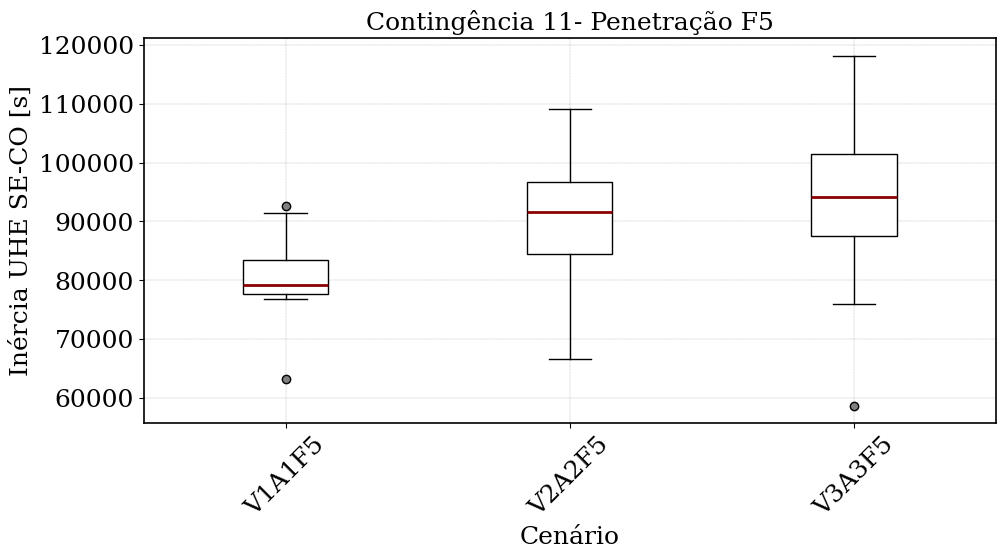

In [7]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases_instab_ang = all_cases_instab_ang.dropna(subset=['UHE_Sudeste-Centro-Oeste'])
plot_boxplot_inertia_FERV(all_cases_instab_ang, contingence=11, ferv='F5', variable='UHE_Sudeste-Centro-Oeste', Yname = 'Inércia UHE SE-CO [s]', path_save_comp = base_path, name = 'ineria_instabANG_UHE_SECO_')

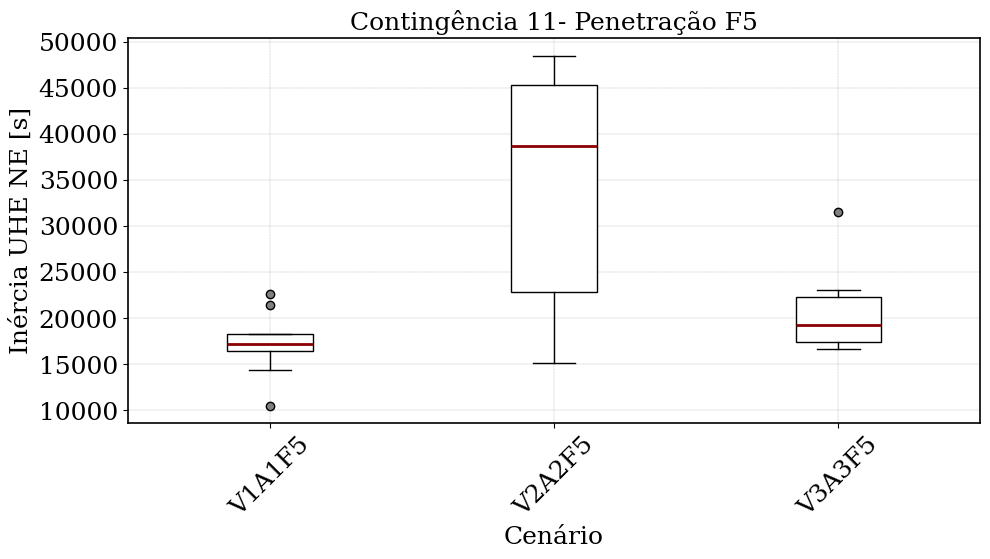

In [9]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases_instab_ang = all_cases_instab_ang.dropna(subset=['UHE_Nordeste'])
plot_boxplot_inertia_FERV(all_cases_instab_ang, contingence=11, ferv='F5', variable='UHE_Nordeste', Yname = 'Inércia UHE NE [s]', path_save_comp = base_path, name = 'ineria_instabANG_UHE_NE_')

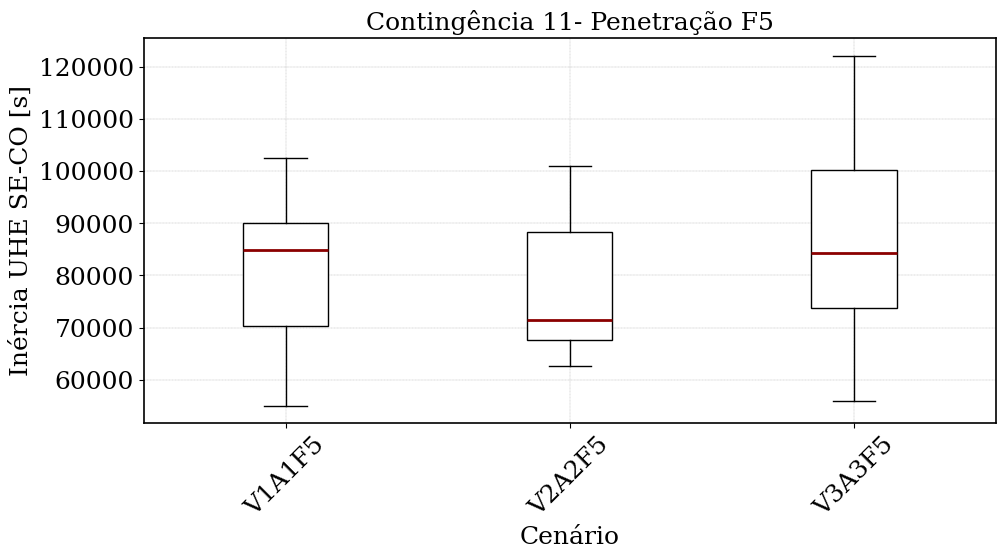

In [8]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases_instab_volt = all_cases_instab_volt.dropna(subset=['UHE_Sudeste-Centro-Oeste'])
plot_boxplot_inertia_FERV(all_cases_instab_volt, contingence=11, ferv='F5', variable='UHE_Sudeste-Centro-Oeste', Yname = 'Inércia UHE SE-CO [s]', path_save_comp = base_path, name = 'ineria_instabVOLT_UHE_SECO_')

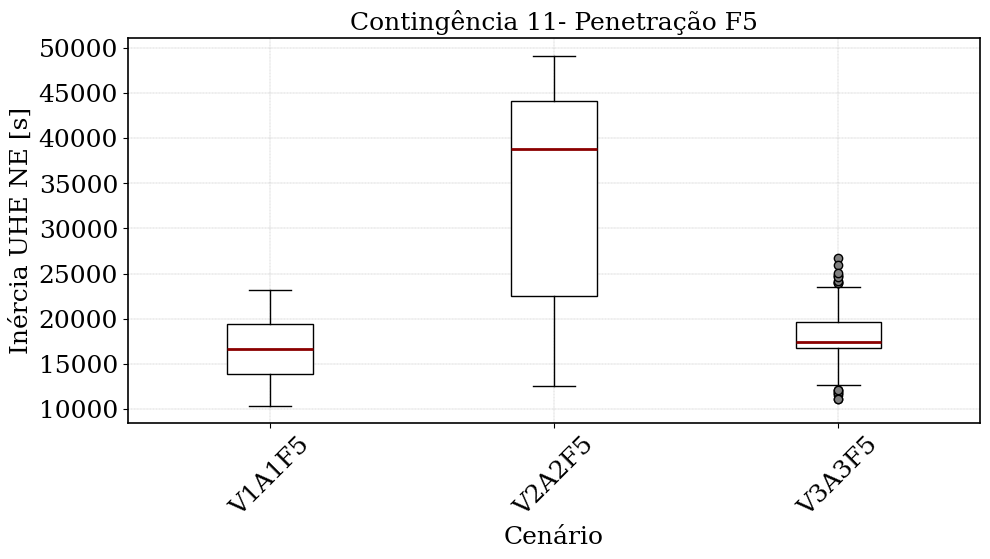

In [10]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases_instab_volt = all_cases_instab_volt.dropna(subset=['UHE_Nordeste'])
plot_boxplot_inertia_FERV(all_cases_instab_volt, contingence=11, ferv='F5', variable='UHE_Nordeste', Yname = 'Inércia UHE NE [s]', path_save_comp = base_path, name = 'ineria_instabVOLT_UHE_NE_')

## Inércia por Região

In [ ]:
#base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
#all_cases = all_cases.dropna(subset=['INRT Nordeste'])
#plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='INRT Nordeste', Yname = 'Inércia NE [s]', path_save_comp = base_path, name = 'ineria_NE_')

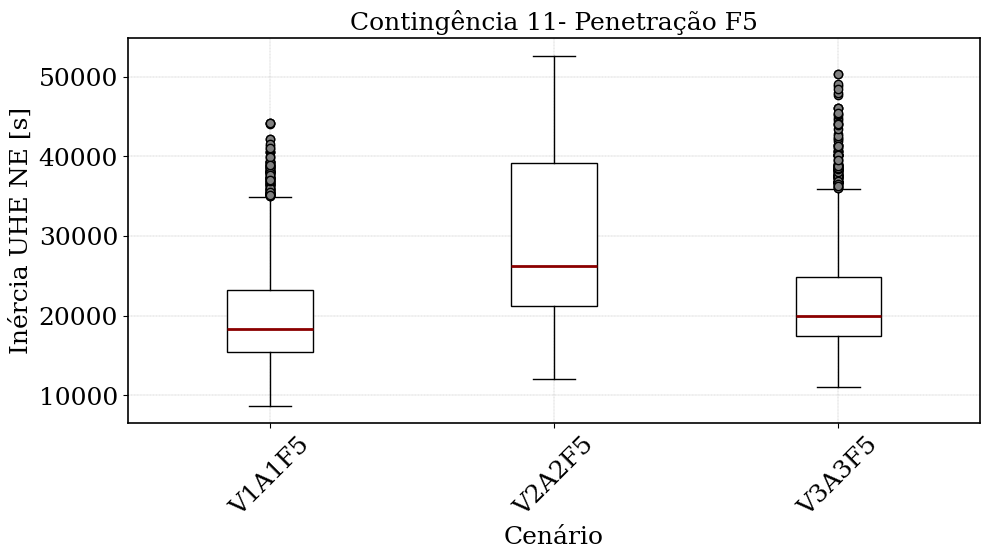

In [11]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UHE_Nordeste'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UHE_Nordeste', Yname = 'Inércia UHE NE [s]', path_save_comp = base_path, name = 'ineria_UHE_NE_')

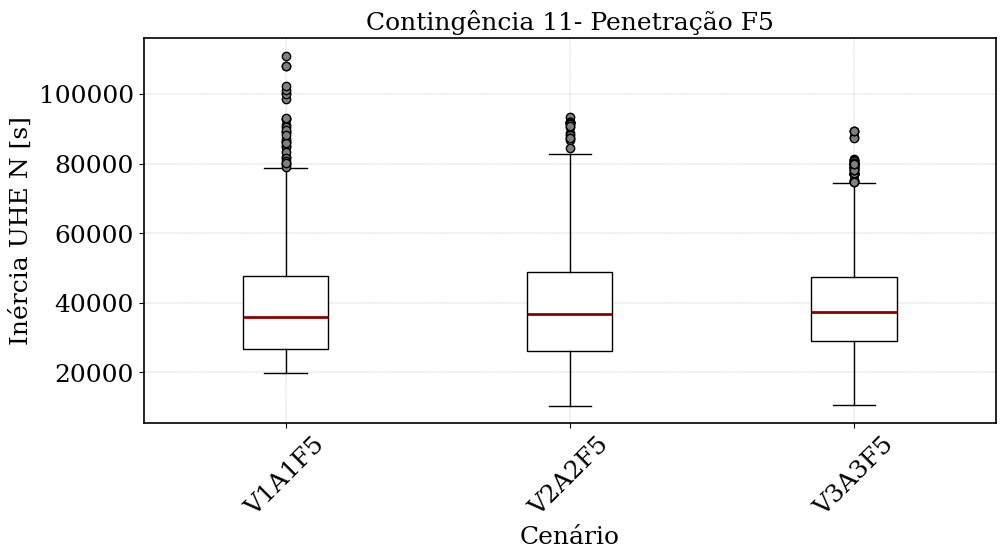

In [12]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UHE_Norte'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UHE_Norte', Yname = 'Inércia UHE N [s]', path_save_comp = base_path, name = 'ineria_UHE_N_')

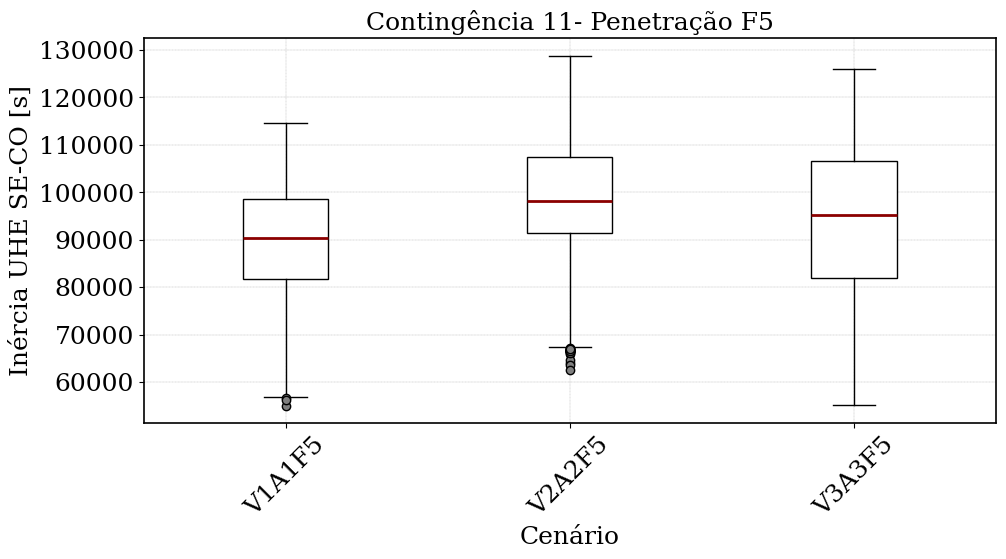

In [13]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UHE_Sudeste-Centro-Oeste'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UHE_Sudeste-Centro-Oeste', Yname = 'Inércia UHE SE-CO [s]', path_save_comp = base_path, name = 'ineria_UHE_SECO_')

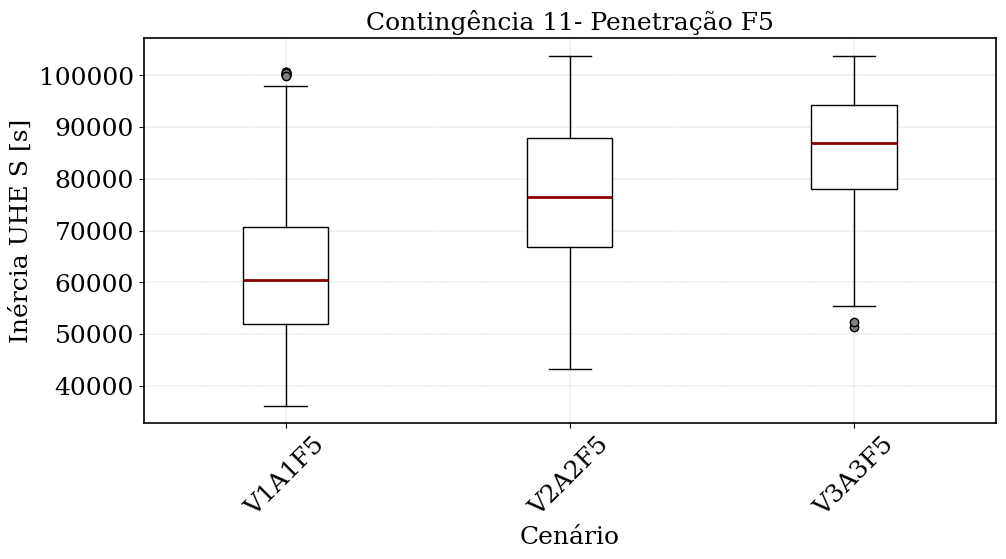

In [14]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UHE_Sul'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UHE_Sul', Yname = 'Inércia UHE S [s]', path_save_comp = base_path, name = 'ineria_UHE_S_')

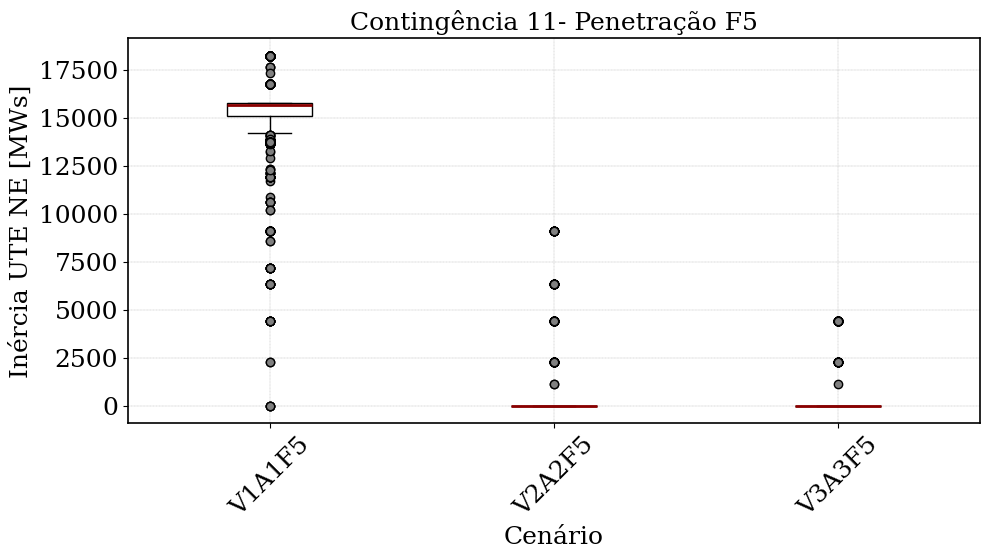

In [15]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UTE_Nordeste'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UTE_Nordeste', Yname = 'Inércia UTE NE [MWs]', path_save_comp = base_path, name = 'ineria_UTE_NE_')

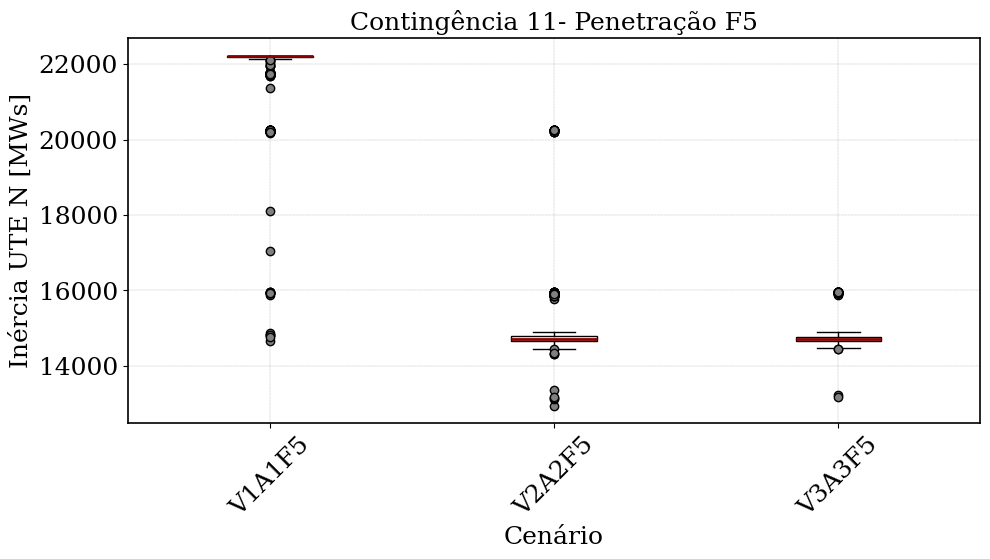

In [16]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UTE_Norte'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UTE_Norte', Yname = 'Inércia UTE N [MWs]', path_save_comp = base_path, name = 'ineria_UTE_N_')

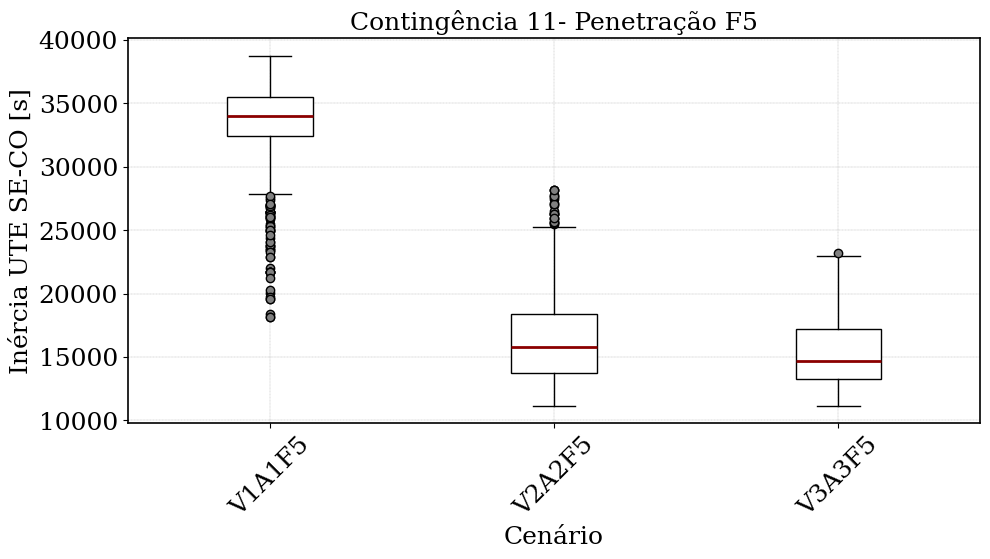

In [17]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UTE_Sudeste-Centro-Oeste'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UTE_Sudeste-Centro-Oeste', Yname = 'Inércia UTE SE-CO [s]', path_save_comp = base_path, name = 'ineria_UTE_SECO_')

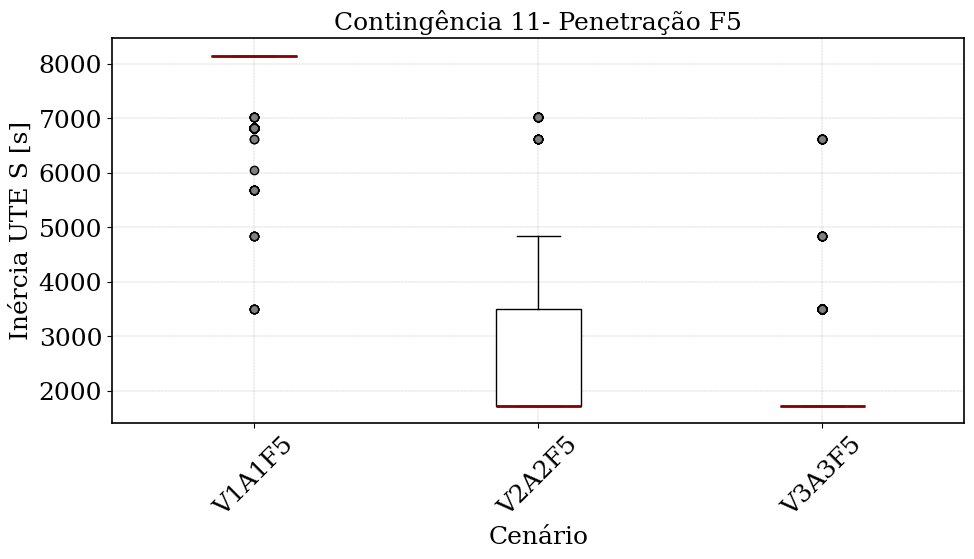

In [18]:
base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
all_cases = all_cases.dropna(subset=['UTE_Sul'])
plot_boxplot_inertia_FERV(all_cases, contingence=11, ferv='F5', variable='UTE_Sul', Yname = 'Inércia UTE S [s]', path_save_comp = base_path, name = 'ineria_UTE_S_')

## Avaliação por Contingência

In [ ]:
contingency_number = 51
filt_data = all_cases[(all_cases['Contigence'] == contingency_number)&(all_cases['A_RCFC'] < 0.1)]

base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
name = 'rocof_hSECO-hSul_' + str(contingency_number)
plot_XYZ(filt_data, "UHE_Sudeste-Centro-Oeste", 'A_RCFC', 'UHE_Sul', 'Inércia SE-CO [MWs/MVA]', 'RoCoF [Hz/s]', 'Inércia S [MWs/MVA]', base_path, name)

base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
name = 'rocof_hSECO-hNE_'+ str(contingency_number)
plot_XYZ(filt_data, "UHE_Sudeste-Centro-Oeste", 'A_RCFC', 'UHE_Nordeste', 'Inércia SE-CO [MWs/MVA]', 'RoCoF [Hz/s]', 'Inércia NE [MWs/MVA]', base_path, name)


base_path = 'G:/Meu Drive/0 Doutorado/00 FERV/000 2026/2026 Reserva Reduzida/'
name = 'rocof_hSECO-hN_'+ str(contingency_number)
plot_XYZ(filt_data, "UHE_Sudeste-Centro-Oeste", 'A_RCFC', 'UHE_Norte', 'Inércia SE-CO [MWs/MVA]', 'RoCoF [Hz/s]', 'Inércia N [MWs/MVA]', base_path, name)